In [41]:
import requests
import json
import re
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
API_KEY = 'RGAPI-5b1aae35-12e5-4c9c-bc40-64b7acdd558b'
FEATURED_GAMES_URL = f'https://na1.api.riotgames.com/lol/spectator/v4/featured-games?api_key={API_KEY}'
SUMMONER_INFO_URL = 'https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/'
MATCH_ID_URL = 'https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/'
MATCH_INFO_URL = 'https://americas.api.riotgames.com/lol/match/v5/matches/'

In [ ]:
# getting a list of currently featured games
games_req = requests.get(FEATURED_GAMES_URL).text
all_games = json.loads(games_req)

# gathering names of all players in each featured game
summoners = []
for game in all_games['gameList']:
    for particpant in game['participants']:
        summoners.append(particpant['summonerName'])

# gathering the encrypted puuids of each summoner and then finding the match_ids of their first 20 recent matches.
match_ids = []
for summoner in summoners:
    url = f'{SUMMONER_INFO_URL}{summoner}?api_key={API_KEY}'
    summoner_req = requests.get(url).text
    summoner_info = json.loads(summoner_req)

    COUNT = 20
    url = f'{MATCH_ID_URL}{summoner_info["puuid"]}/ids?start=0&count={COUNT}&api_key={API_KEY}'
    match_ids_req = requests.get(url).text
    matches = json.loads(match_ids_req)

    match_ids += matches


In [3]:
matches = []

with open('saved-match-ids.txt') as file:
    text = file.readlines()
    pattern = r"NA1_\d{10}"

    matches = re.findall(pattern, text[0])

with open('saved-match-data.txt') as file:
    text = file.readlines()
    pattern = r"NA1_\d{10}"

    matches += re.findall(pattern, text[0]) 

matches = list(set(matches))

In [4]:
kda = []
win = []
vision = []
participant_match_id = []
game_mode = []

for match in matches:
    url = f'{MATCH_INFO_URL}{match}?api_key={API_KEY}'
    match_info_req = requests.get(url)

    if hasattr(match_info_req, 'text') and 'info' in match_info_req.text:
        info = json.loads(match_info_req.text)['info']

        for particpant in info['participants']:
            if 'challenges' in particpant:
                participant_match_id.append(match)
                kda.append(particpant['challenges']['kda'])
                game_mode.append(info['gameMode'])
                win.append(particpant['win'])
                vision.append(particpant['challenges']['visionScorePerMinute'])




In [20]:
df = pd.DataFrame()

df['match_id'] = participant_match_id
df['kda'] = kda
df['vision'] = vision
df['win'] = win
df['game_mode'] = game_mode

df = df[df['game_mode'] == 'CLASSIC']
df = df.reset_index()
df = df.drop(labels='index', axis=1)
df

,match_id,kda,vision,win,game_mode
0,NA1_4283435623,0.750000,0.502529,False,CLASSIC
1,NA1_4283435623,1.250000,0.720630,False,CLASSIC
2,NA1_4283435623,1.600000,0.410884,False,CLASSIC
3,NA1_4283435623,13.000000,0.607956,False,CLASSIC
4,NA1_4283435623,1.181818,2.205942,False,CLASSIC
...,...,...,...,...,...
2150,NA1_4281919129,0.750000,0.260928,False,CLASSIC
2151,NA1_4281919129,2.444444,1.596563,False,CLASSIC
2152,NA1_4281919129,2.900000,0.183269,False,CLASSIC
2153,NA1_4281919129,2.500000,1.371148,False,CLASSIC


In [ ]:
df = pd.DataFrame()

df['match_id'] = participant_match_id
df['kda'] = kda
df['vision'] = vision
df['win'] = win
df['game_mode'] = game_mode

df = df[df['game_mode'] == 'CLASSIC']
df = df.reset_index()
df = df.drop(labels='index', axis=1)
df

In [58]:
SVM_df = df.drop(labels=['match_id', 'game_mode'], axis=1)
SVM_df = SVM_df.replace({'win' : {False : 0, True : 1} })

xx, yy = np.meshgrid(np.linspace(0, SVM_df['kda'].max() , 500), np.linspace(0, SVM_df['vision'].max(), 500))

X = SVM_df.drop('win', axis=1)
Y = SVM_df['win']

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

clf = svm.NuSVC(gamma="auto")
clf.fit(X, Y)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(


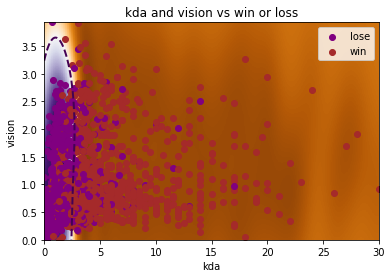

In [57]:
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")

w_checked = False
l_checked = False

for index, row in SVM_df.iterrows():
    if row['win'] == 0:  
        if not l_checked:
            plt.scatter(row['kda'], row['vision'], c='purple', label='lose')
            l_checked = True
        else:
            plt.scatter(row['kda'], row['vision'], c='purple')
    else:
        if not w_checked:
            plt.scatter(row['kda'], row['vision'], c='brown', label='win')
            w_checked = True
        else:
            plt.scatter(row['kda'], row['vision'], c='brown')

plt.legend()
plt.xticks()
plt.yticks()

plt.title('kda and vision vs win or loss')
plt.xlabel('kda')
plt.ylabel('vision')
plt.axis([0, SVM_df['kda'].max(), 0, SVM_df['vision'].max()])
plt.show()